********************************************************************************************************************************************************
Analysis of Image: kodim24.png
For Quality Factor: 10
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 28.19 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 13.62
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_with_rle/reconstruct_img_rle_24_qf10.png
For Quality Factor: 20
Original Image Size: 384.00 KB
DCT Coefficients Size: 1536.00 KB
Quantized Coefficients Size: 768.00 KB
Encoded Data Size: 43.57 KB

Compression Ratios:
Original to DCT Ratio: 0.25
Original to Quantized Ratio: 0.50
Original to Encoded Ratio: 8.81
Reconstructed image saved as /home/ssaral/Downloads/CS663_Project/compressed_with_rle/reconstruct_img_rle_24_qf20.png
For Quality Factor: 30
Original Image S

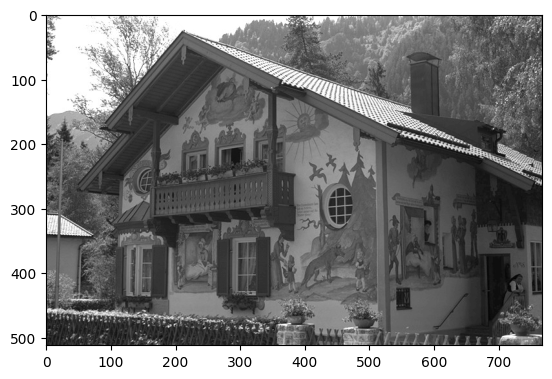

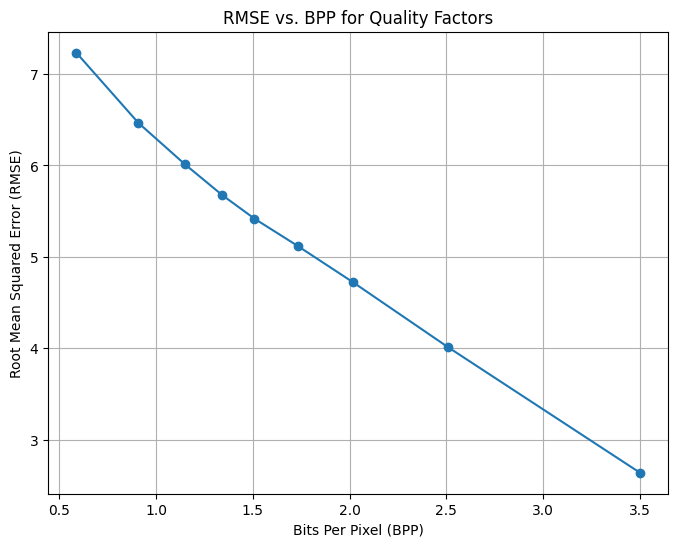

In [5]:
import os
import cv2
import numpy as np
from scipy.fftpack import dct, idct
from collections import Counter
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import heapq
from PIL import Image

# Quantization table for luminance (Y)
QY = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

# Zig-Zag Traversal
def zigzag_order(block):
    zigzag_list = []
    n = len(block)
    for i in range(2 * n - 1):
        if i < n:
            row = 0
            col = i
        else:
            row = i - (n - 1)
            col = n - 1
        diagonal = []
        while row < n and col >= 0:
            diagonal.append(block[row][col])
            row += 1
            col -= 1
        if i % 2 != 0:
            diagonal.reverse()
        zigzag_list.extend(diagonal)
    return zigzag_list

# Inverse Zig-Zag
def inverse_zigzag(zigzag_list, block_size=8):
    block = np.zeros((block_size, block_size), dtype=np.int32)
    n = block_size
    index = 0
    for i in range(2 * n - 1):
        if i < n:
            row = 0
            col = i
        else:
            row = i - (n - 1)
            col = n - 1
        diagonal = []
        while row < n and col >= 0:
            diagonal.append((row,col))
            row += 1
            col -= 1
        if i%2 != 0:
            diagonal.reverse()
        
        for r, c in diagonal:
            block[r][c] = zigzag_list[index]
            index += 1
            
    return block


# RLE Encoding
def rle_encode(zigzag_list):
    encoded = []
    count = 1
    for i in range(1, len(zigzag_list)):
        if zigzag_list[i] == zigzag_list[i - 1]:
            count += 1
        else:
            encoded.append((zigzag_list[i - 1], count))
            count = 1
    encoded.append((zigzag_list[-1], count))
    return encoded

# RLE Decoding
def rle_decode(encoded):
    decoded = []
    for value, count in encoded:
        decoded.extend([value] * count)
    return decoded


# Huffman Encoding
class HuffmanNode:
    def __init__(self, value=None, frequency=0, left=None, right=None):
        self.value = value
        self.frequency = frequency
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.frequency < other.frequency

def build_huffman_tree(frequency_table):
    heap = [HuffmanNode(value, freq) for value, freq in frequency_table.items()]
    heapq.heapify(heap)
    
    while len(heap) > 1:
        left = heapq.heappop(heap)
        right = heapq.heappop(heap)
        merged = HuffmanNode(frequency=left.frequency + right.frequency, left=left, right=right)
        heapq.heappush(heap, merged)
    
    return heap[0]

def generate_huffman_codes(node, prefix="", codebook={}):
    if node.value is not None:
        codebook[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + "0", codebook)
        generate_huffman_codes(node.right, prefix + "1", codebook)
    return codebook

def huffman_encode(data):
    frequency_table = Counter(data)
    root = build_huffman_tree(frequency_table)
    codebook = generate_huffman_codes(root)
    encoded_data = "".join(codebook[value] for value in data)
    return encoded_data, codebook

def huffman_decode(encoded_data, codebook):
    reverse_codebook = {v: k for k, v in codebook.items()}
    decoded_data = []
    buffer = ""
    for bit in encoded_data:
        buffer += bit
        if buffer in reverse_codebook:
            decoded_data.append(reverse_codebook[buffer])
            buffer = ""
    return decoded_data

# RMSE Calculation
def calculate_rmse(original_image, reconstructed_image):
    rmse = np.sqrt(mean_squared_error(original_image.flatten(), reconstructed_image.flatten()))
    return rmse

# JPEG Compression Functions
def split_into_blocks(image, block_size=8):
    h, w = image.shape
    return [image[i:i+block_size, j:j+block_size] for i in range(0, h, block_size) for j in range(0, w, block_size)]

def apply_dct(blocks):
    return [dct(dct(block.T, norm='ortho').T, norm='ortho') for block in blocks]

def quantize(blocks, quant_matrix):
    return [np.round(block / quant_matrix).astype(np.int32) for block in blocks]

def dequantize(blocks, quant_matrix):
    return [block * quant_matrix for block in blocks]
  
def apply_idct(blocks):
    return [idct(idct(block.T, norm='ortho').T, norm='ortho') for block in blocks]

def merge_blocks(blocks, image_shape, block_size=8):
    h, w = image_shape
    image = np.zeros((h, w))
    idx = 0
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            image[i:i+block_size, j:j+block_size] = blocks[idx]
            idx += 1
    return image

def jpeg_compression_grayscale(image, quality_factor=50):
    scale = 50 / quality_factor if quality_factor < 50 else 2 - quality_factor / 50
    qy = np.clip(QY * scale, 1, 255).astype(np.int32)
    blocks = split_into_blocks(image)
    dct_blocks = apply_dct(blocks)
    quantized_blocks = quantize(dct_blocks, qy)
    return quantized_blocks, qy, image.shape

def jpeg_decompression_grayscale(quantized_blocks, quant_matrix, original_shape):
    dequantized_blocks = [block * quant_matrix for block in quantized_blocks]
    idct_blocks = apply_idct(dequantized_blocks)
    decompressed_image = merge_blocks(idct_blocks, original_shape)
    return np.clip(decompressed_image, 0, 255).astype(np.uint8)

def save_compressed_data(rle_blocks, encoded_data, codebook, quant_matrix, filename="compressed_image.bin"):
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump({
            'rle_blocks': rle_blocks,
            'encoded_data': encoded_data,
            'codebook': codebook,
            'quant_matrix': quant_matrix
        }, f)

import pickle

def load_compressed_data(filename="compressed_image.bin"):
    with open(filename, 'rb') as f:
        return pickle.load(f)

def save_as_jpeg(image, reconstructed_filename, qf):
    pil_image = Image.fromarray(image)  # Convert numpy array to PIL Image
    reconstructed_filename = reconstructed_filename.replace(".png", f"_qf{qf}.png")
    pil_image.save(reconstructed_filename, "JPEG")
    print(f"Reconstructed image saved as {reconstructed_filename}")

def calculate_sizes_and_ratios(images, encoded_data, qf):
    # Image size (Original)
    height, width = images.shape
    original_size_bits = height * width * 8  # 8 bits per pixel
    dct_size_bits = height * width * 32  # 32 bits per coefficient
    quantized_size_bits = height * width * 16  # 16 bits per coefficient
    encoded_size_bits = len(encoded_data)  # Size of the compressed bitstream
    
    # Compression Ratios
    dct_ratio = original_size_bits / dct_size_bits
    quantized_ratio = original_size_bits / quantized_size_bits
    encoded_ratio = original_size_bits / encoded_size_bits
    print("======================================================================")
    print(f"For Quality Factor: {qf}")
    print(f"Original Image Size: {original_size_bits / 8 / 1024:.2f} KB")
    print(f"DCT Coefficients Size: {dct_size_bits / 8 / 1024:.2f} KB")
    print(f"Quantized Coefficients Size: {quantized_size_bits / 8 / 1024:.2f} KB")
    print(f"Encoded Data Size: {encoded_size_bits / 8 / 1024:.2f} KB")
    
    print("\nCompression Ratios:")
    print(f"Original to DCT Ratio: {dct_ratio:.2f}")
    print(f"Original to Quantized Ratio: {quantized_ratio:.2f}")
    print(f"Original to Encoded Ratio: {encoded_ratio:.2f}")


# RMSE vs BPP Analysis
def rmse_vs_bpp_analysis(image, quality_factors, save_path, reconstruct_img_save_path):
    bpps = []
    rmses = []

    for qf in quality_factors:
        quantized_blocks, quant_matrix, img_shape = jpeg_compression_grayscale(image, quality_factor=qf)
        zigzag_blocks = [zigzag_order(block) for block in quantized_blocks]
        rle_blocks = [rle_encode(block) for block in zigzag_blocks]
        flattened_data = [item for block in rle_blocks for sublist in block for item in sublist]
        encoded_data, codebook = huffman_encode(flattened_data)
        
        calculate_sizes_and_ratios(image, encoded_data, qf)
        save_compressed_data(rle_blocks, encoded_data, codebook, quant_matrix)

        data = load_compressed_data("compressed_image.bin")
        rle_blocks = data['rle_blocks']
        codebook = data['codebook']
        encoded_data = data['encoded_data']
        quant_matrix = data['quant_matrix']

        # Decompression
        huffman_decoded = huffman_decode(encoded_data, codebook)
        rle_blocks = []  # Reconstructed RLE blocks
        current_block = []
        block_len = 0
        for i in range(0, len(huffman_decoded), 2):  # RLE has pairs (value, count)
            current_block.append((huffman_decoded[i], huffman_decoded[i + 1]))
            block_len += huffman_decoded[i + 1]
            if block_len == 64:  # Full RLE block reconstructed
                rle_blocks.append(current_block)
                current_block = []
                block_len = 0
        
        zigzag_blocks_decoded = [rle_decode(block) for block in rle_blocks]
        quantized_blocks_decoded = [inverse_zigzag(block, block_size=8) for block in zigzag_blocks_decoded]
        reconstructed_image = jpeg_decompression_grayscale(quantized_blocks_decoded, quant_matrix, img_shape)

        plt.imshow(reconstructed_image, cmap='gray')
        save_as_jpeg(reconstructed_image, reconstruct_img_save_path, qf)

        # Calculate RMSE and BPP
        rmse = calculate_rmse(image, reconstructed_image)
        bpp = len(encoded_data) / (image.shape[0] * image.shape[1])
        rmses.append(rmse)
        bpps.append(bpp)
    
    # Plot and save graph
    plt.figure(figsize=(8, 6))
    plt.plot(bpps, rmses, marker='o')
    plt.title(f"RMSE vs. BPP for Quality Factors")
    plt.xlabel("Bits Per Pixel (BPP)")
    plt.ylabel("Root Mean Squared Error (RMSE)")
    plt.grid(True)
    plt.savefig(save_path)
    plt.show()

# Main Execution
image_folder = f"/home/ssaral/Downloads/CS663_Project/img/"
output_folder = "/home/ssaral/Downloads/CS663_Project/compressed_with_rle/"
quality_factors = range(10, 100, 10)

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for img_file in sorted(os.listdir(image_folder)):
    if img_file.endswith("24.png"):
        image_id = img_file[5:7]
        img_path = os.path.join(image_folder, img_file)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            print(f"Failed to load image: {img_file}")
            continue
        print("********************************************************************************************************************************************************")
        print(f"Analysis of Image: {img_file}")
        graph_save_path = os.path.join(output_folder, f"rmse_bpp_rle_{image_id}.png")
        reconstruct_img_save_path = os.path.join(output_folder, f"reconstruct_img_rle_{image_id}.png")
        rmse_vs_bpp_analysis(image, quality_factors, graph_save_path, reconstruct_img_save_path)
        
